In [38]:
# Import necessary libraries
import pandas as pd
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from Scripts import preprocessing

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_validate
import optuna
import numpy as np

# Load data
df = pd.read_csv("../data/train_set.csv")

# Split data into training and validation sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, valid_index in split.split(df, df["Cylinders"]):
    train_set = df.loc[train_index]
    valid_set = df.loc[valid_index]

# Separate features and target
X_train = train_set.drop("MPG", axis=1)
y_train = train_set["MPG"].copy()
X_valid = valid_set.drop("MPG", axis=1)
y_valid = valid_set["MPG"].copy()

# Initialize LazyRegressor and fit the model
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_valid, y_train, y_valid)
model_dictionary = reg.provide_models(X_train, X_valid, y_train, y_valid)

100%|██████████| 42/42 [00:04<00:00, 10.03it/s]


In [39]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.89,0.90,2.13,0.21
GradientBoostingRegressor,0.87,0.88,2.35,0.15
HistGradientBoostingRegressor,0.86,0.87,2.47,0.27
LGBMRegressor,0.85,0.86,2.51,0.04
RandomForestRegressor,0.85,0.86,2.54,0.29
KNeighborsRegressor,0.84,0.85,2.61,0.02
BaggingRegressor,0.83,0.85,2.66,0.10
SVR,0.83,0.84,2.71,0.02
XGBRegressor,0.83,0.84,2.71,0.08


In [40]:
model_dictionary['GradientBoostingRegressor']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Origin'],
      dtype='object')),
                                                 ('categorical_low',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index([], dtype='object')),
                                                 ('categorical_high',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  Index([], dtype='object'))])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

In [41]:
X_train, y_train, scaler = preprocessing.preprocess(train_set,train=True)
X_valid, y_valid, scaler = preprocessing.preprocess(valid_set,scaler=scaler)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
val_predictions = model.predict(X_valid)
baseline_rmse = np.sqrt(mean_squared_error(y_valid, val_predictions))
print(f'the baseline rmse is : {baseline_rmse}')

the baseline rmse is : 2.2991369212470567


#### Hyperparameter Tuning using Optuna
Optuna is a software framework for automating the optimization process of these hyperparameters. It automatically finds optimal hyperparameter values by making use of different samplers such as grid search, random, bayesian, and evolutionary algorithms.

Now, we will create the objective function and define the search space:
We built a grid of 5 hyperparameters with different ranges and some static ones for random seed and early stopping.

In [42]:
def objective(trial, X, y, cv, scoring):
    params = {
        # "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        # "min_samples_split": trial.suggest_int("min_samples_split", 2,9),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1,9),
        # "subsample": trial.suggest_float("subsample", 0.1, 0.9, step=0.05),
        # "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "random_state": 42,
        "n_iter_no_change": 50,  # early stopping
        "validation_fraction": 0.05,
    }
    # Perform CV
    gr_reg = GradientBoostingRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    # Compute RMSLE
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse

The above objective function is slightly different - it accepts additional arguments for the data sets, scoring and cv. That's why we have to wrap it inside another function

In [43]:
%%time

# Separate features and target
X, y, scaler = preprocessing.preprocess(df,train=True)

# Create study that minimizes
study = optuna.create_study(direction="minimize")

# Wrap the objective inside a lambda with the relevant arguments
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Pass additional arguments inside another function
func = lambda trial: objective(trial, X, y, cv=kf, scoring="neg_mean_squared_error")

# Start optimizing with 100 trials
study.optimize(func, n_trials=200)

[I 2023-03-28 23:03:01,134] A new study created in memory with name: no-name-71d75b41-8f56-42c6-980f-8a5e4f48a41b
[I 2023-03-28 23:03:01,527] Trial 0 finished with value: 7.328109896932511 and parameters: {'learning_rate': 0.0006102840153819365, 'max_depth': 3}. Best is trial 0 with value: 7.328109896932511.
[I 2023-03-28 23:03:01,787] Trial 1 finished with value: 3.032259172417746 and parameters: {'learning_rate': 0.07844449711219408, 'max_depth': 1}. Best is trial 1 with value: 3.032259172417746.
[I 2023-03-28 23:03:02,142] Trial 2 finished with value: 3.685176020751012 and parameters: {'learning_rate': 0.012873653445270411, 'max_depth': 3}. Best is trial 1 with value: 3.032259172417746.
[I 2023-03-28 23:03:02,421] Trial 3 finished with value: 7.579215413898119 and parameters: {'learning_rate': 0.0002553805932820591, 'max_depth': 1}. Best is trial 1 with value: 3.032259172417746.
[I 2023-03-28 23:03:03,105] Trial 4 finished with value: 6.809820559355821 and parameters: {'learning_rat

CPU times: total: 8.73 s
Wall time: 1min 5s


In [44]:
print(f"Optimized RMSE: {study.best_value:.5f}")

Optimized RMSE: 2.74077


n just under a minute, we achieved a significant score boost (in terms of log errors, 0.004 is pretty sweet). We did this with only 100 trials. Let's boldly run another 200 and see what happens:

In [45]:
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	learning_rate: 0.18159316787415972
	max_depth: 2


Most importantly, we achieved this score in just over 2 minutes using a search space that would probably take hours with regular GridSearch.

Optuna offers a wide range of plots under its visualization subpackage. Here, we will discuss only 2, which I think are the most useful.

First, let's plot the optimization history of the last study:

In [46]:
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

This plot tells us that Optuna made the score converge to the minimum after only a few trials.

Next, let's plot hyperparameter importances:

In [47]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show(config=plotly_config)

This plot is massively useful! It tells us several things, including:

max_depth and learning_rate are the most important
subsample and max_features are useless for minimizing the loss
A plot like this comes in handy when tuning models with many hyperparameters. For example, you could take a test run of 40–50 trials and plot the parameter importances.

Depending on the plot, you might decide to discard some less important parameters and give a larger search space for other ones, possibly reducing the search time and space.

In [72]:
best_params=study.best_params
model= GradientBoostingRegressor(**best_params)
model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.18159316787415972, max_depth=2)

In [73]:

df = pd.read_csv("../data/test_set.csv")

# Separate features and target

X_test, y_test, scaler = preprocessing.preprocess(df,scaler=scaler)

final_predictions = model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

2.858551423909045

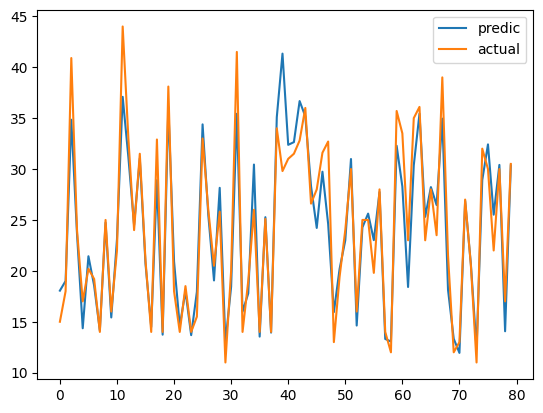

In [75]:
import matplotlib.pyplot as plt
plt.plot(final_predictions,label='predic')
plt.plot(y_test,label='actual')
plt.legend()

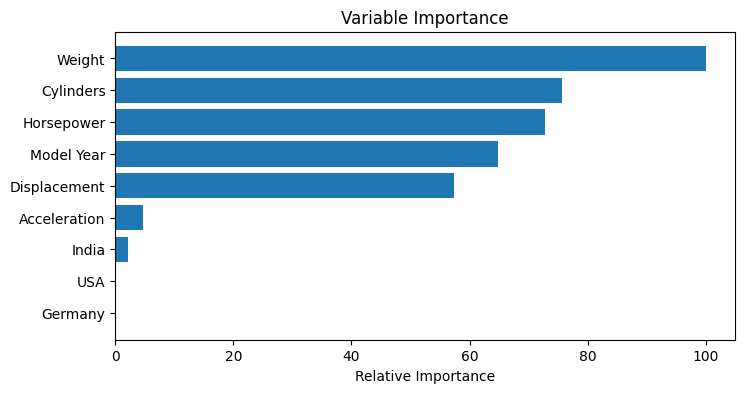

In [77]:
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()